# Import libraries & data

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [67]:
customer_df = pd.read_csv('we_fn_use_c_marketing_customer_value_analysis.csv')

# Lab 1 - Numerical data cleaning

In [68]:
# No NaNs values in the dataset

display(customer_df.info()) # or this code for nulls: customer_df.isnull().sum()/len(customer_df). But we can see already w/ info 
display(customer_df.shape)
customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

None

(9134, 24)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [69]:
customer_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Lifetime Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly Premium Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months Since Last Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months Since Policy Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number of Open Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number of Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total Claim Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678


In [70]:
# For loop to replace the column headers with lowercase snake format

n_cols = []
for i in range(len(customer_df.columns)):
    n_cols.append(customer_df.columns[i].lower().replace(' ','_'))

customer_df.columns = n_cols


In [71]:
# The above code did not fix employmentstatus so I've done this. I'm sure there is a way to do it in the loop with regex...

customer_df = customer_df.rename(columns = {'employmentstatus':'employment_status'})

In [72]:
# Change effective to date into a datetime format column

customer_df['effective_to_date']=pd.to_datetime(customer_df['effective_to_date'])

In [73]:
# To understand the data better (and clean as appropriate), we will start by separating numerical from the categorical

numerical = customer_df.select_dtypes(include=np.number)
categorical = customer_df.select_dtypes(include=object)

In [74]:
# In the numerical data, we need to separate the continuous from discrete variables

discrete_lst = []
continuous_lst = []
for col in numerical.columns:
    if len(numerical[col].unique()) < (numerical.shape[0] * 0.02):
        discrete_lst.append(col)
    else:
        continuous_lst.append(col)
display(discrete_lst)
display(continuous_lst)

['months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies']

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'total_claim_amount']

In [75]:
# Function to pass the discrete / continuous split to the numerical dataset

def discrete_continuous(df):
    discrete_lst = []
    continuous_lst = []
    for col in numerical.columns:
        if len(numerical[col].unique()) < (numerical.shape[0] * 0.02):
            discrete_lst.append(col)
        else:
            continuous_lst.append(col)
    return (discrete_lst, continuous_lst)

In [76]:
# Apply the function

discrete_lst, continuous_lst = discrete_continuous(numerical)

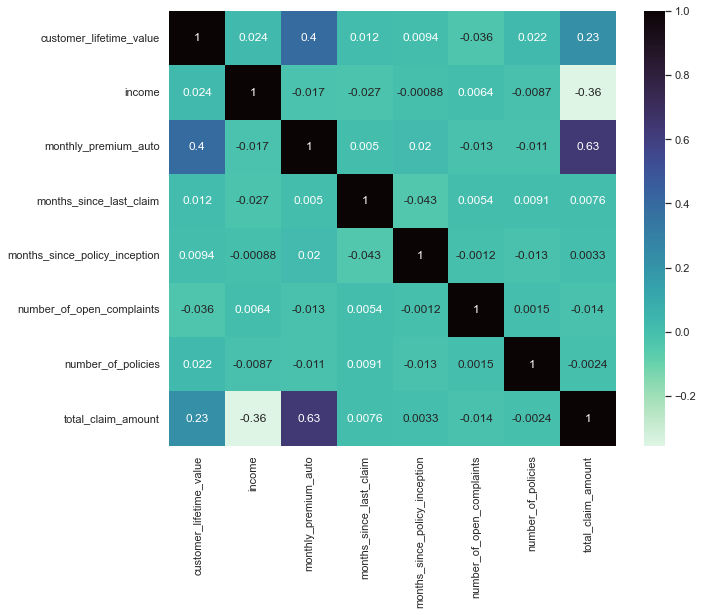

In [77]:
# Plot a correlation matrix
# We see that monthly_premium_auto is moderately correlated with both customer_lifetime_value (0.4) and total_claim_amount (0.63)
# Total_claim_amount has a weak negative correlation with income (-0.36)
# Nothing here would lead us to cut out a column in the numerical data

correlations = numerical.corr()

fig, ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(correlations, cmap='mako_r', annot=True)
plt.show()

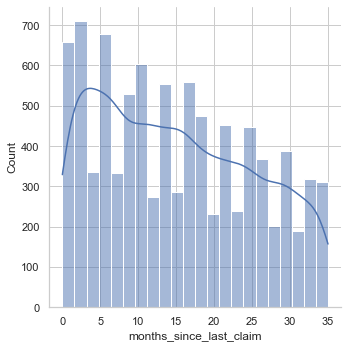

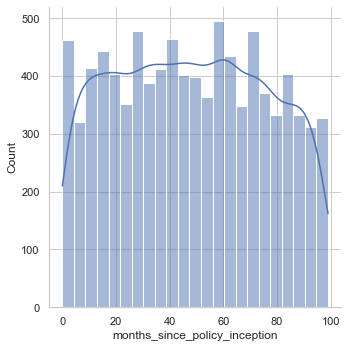

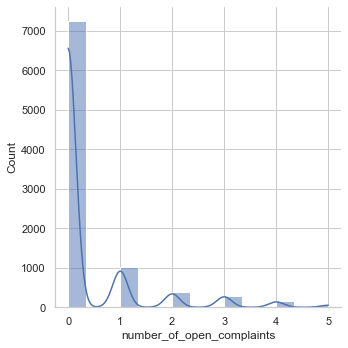

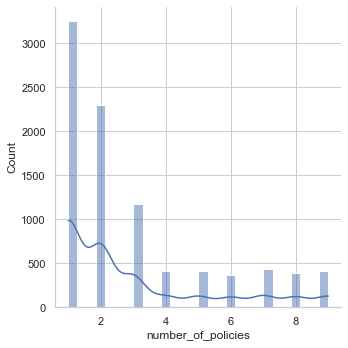

In [78]:
# Plot the numerical variables to see their skew / distributions
# Note: These four variables could be converted to categoricals but I don't think it's necessary here

for column in numerical[discrete_lst]:
    sns.displot(numerical[column], kde=True)
    plt.show()

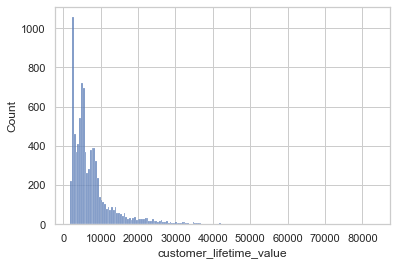

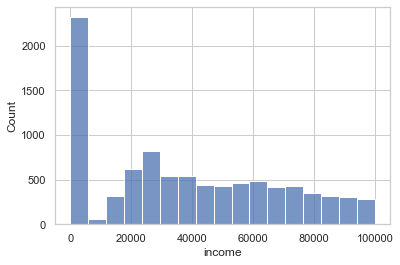

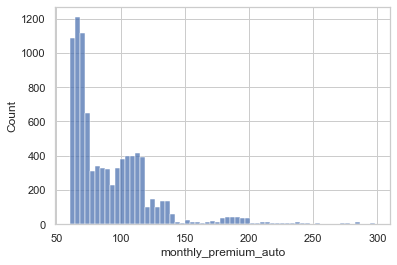

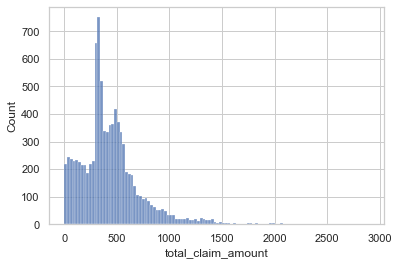

In [79]:
# Plot the categorical variables

for column in numerical[continuous_lst]:
    sns.histplot(numerical[column])
    plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


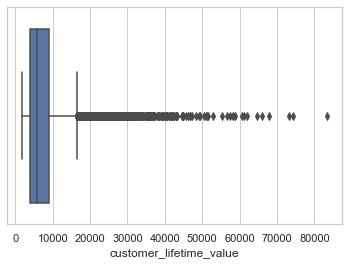

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


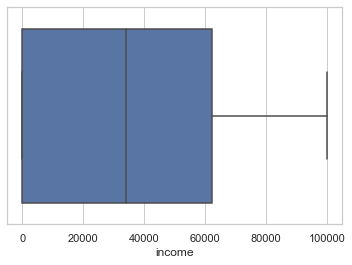

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


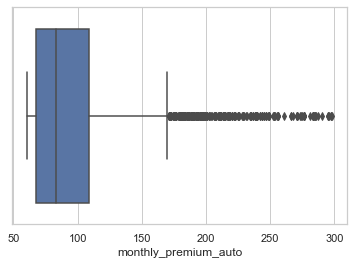

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


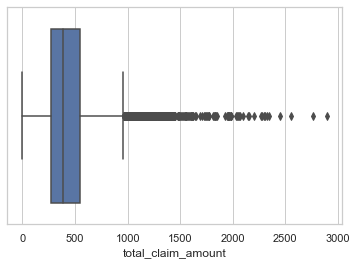

In [80]:
# Checking for outliers in the continuous variables

for column in numerical[continuous_lst]:
    sns.boxplot(numerical[column])
    plt.show()

In [81]:
# Dealing with outliers -- using the IQR and a function to pass it to all variables
# We could also try a log transform (perhaps instead?)

def detect_outlier(column):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(column), [25, 75])
 
    # compute IQR
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in column if x <= lower_bound or x >= upper_bound]
 
    return outliers

In [82]:
clv_outliers = detect_outlier(numerical['customer_lifetime_value'])
tca_outliers = detect_outlier(numerical['total_claim_amount'])
mpa_outliers = detect_outlier(numerical['monthly_premium_auto'])

display(len(clv_outliers), len(tca_outliers), len(mpa_outliers))

customer_df.shape

# Not sure if we want to strike these outliers as it may cause us to lose a lot of data.

# Perhaps a log transform instead?


817

453

430

(9134, 24)

# Lab 2 - categorical data cleaning

In [83]:
# Explore the categorical data for anomalies. We already know from above that there are no NaNs to deal with... 

categorical.head()

,customer,state,response,coverage,education,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,BU79786,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,QZ44356,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,AI49188,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,WW63253,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,HB64268,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


In [84]:
categorical['state'].unique()

array(['Washington', 'Arizona', 'Nevada', 'California', 'Oregon'],
      dtype=object)

In [85]:
# Drop the customer variable because it if not helpful for our analysis

categorical = categorical.drop(['customer'], axis = 1)

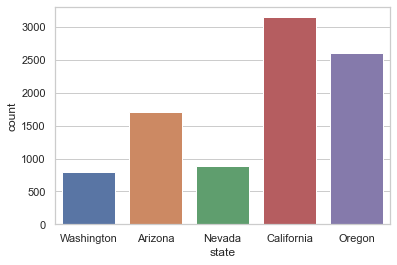

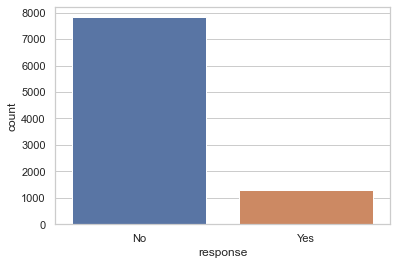

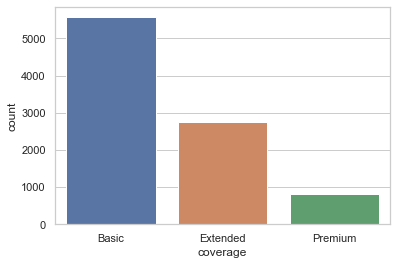

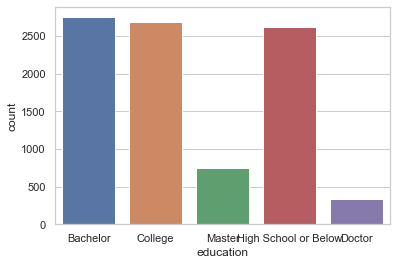

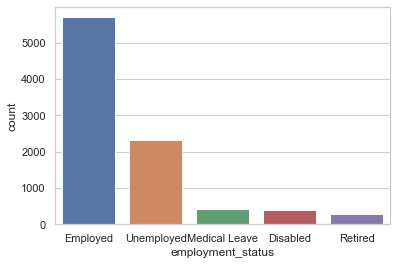

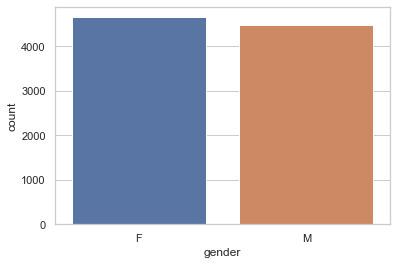

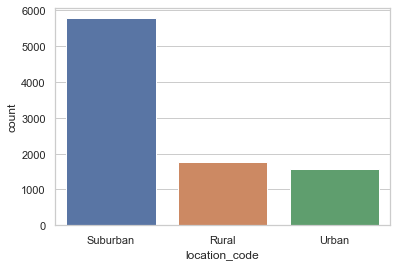

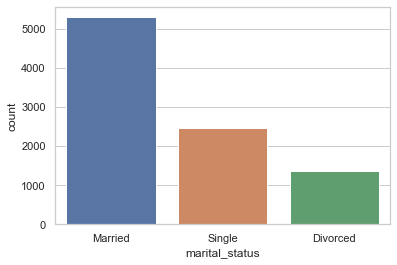

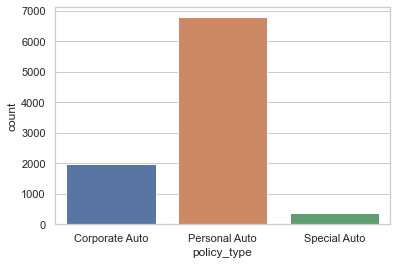

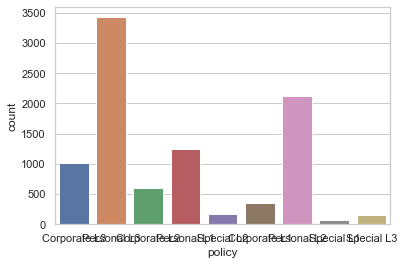

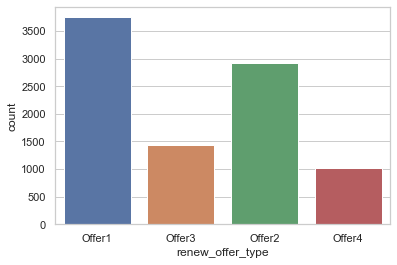

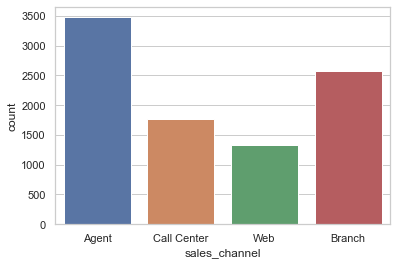

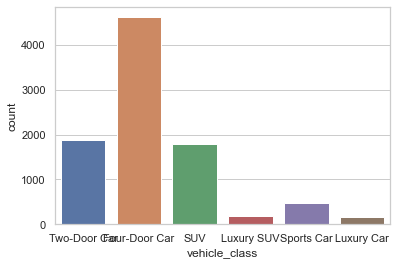

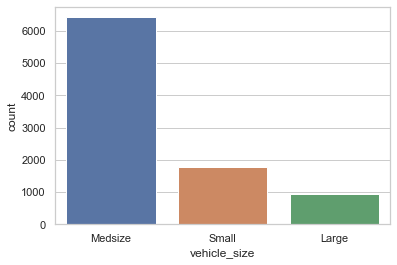

In [86]:
def cntplot_cat(df):
    for column in categorical.columns:
        sns.countplot(x=categorical[column])
        plt.show()
    return None
   
cntplot_cat(categorical)

sns.set_theme(style="whitegrid")

In [87]:
categorical_columns = [col for col in categorical if (len(categorical[col].unique()) < (categorical.shape[0] * 0.01))]

In [88]:
# Fix education -- try to filter it into four categories instead (Note: not sure how college and bachelor differ)

categorical.loc[categorical["education"].isin(['Master','Doctor'])] = "Graduate"

collapse = categorical["education"].value_counts().index[:3]
categorical["education"] = np.where(categorical["education"].isin(collapse), categorical["education"], 'Graduate')
categorical["education"].value_counts(dropna=False)

Bachelor                2748
College                 2681
High School or Below    2622
Graduate                1083
Name: education, dtype: int64

In [89]:
# Run the same operation for vehicle_type

collapse2 = categorical["vehicle_class"].value_counts().index[:3]
categorical["vehicle_class"] = np.where(categorical["vehicle_class"].isin(collapse2), categorical["vehicle_class"], 'Luxury')
categorical["vehicle_class"].value_counts(dropna=False)

Four-Door Car    4073
Luxury           1807
Two-Door Car     1660
SUV              1594
Name: vehicle_class, dtype: int64

In [90]:
# Encode 'response' to be 0 or 1 so we can fix the data imbalance later...

def yes_no(x):
    if x=='Yes':
        return 1
    else:
        return 0

categorical['response'] = list(map(yes_no,categorical['response']))

In [91]:
display(categorical["policy"].value_counts(dropna=False))
categorical["policy_type"].value_counts(dropna=False)

Personal L3     3011
Personal L2     1860
Graduate        1083
Personal L1     1079
Corporate L3     914
Corporate L2     518
Corporate L1     332
Special L2       146
Special L3       134
Special L1        57
Name: policy, dtype: int64

Personal Auto     5950
Corporate Auto    1764
Graduate          1083
Special Auto       337
Name: policy_type, dtype: int64

In [92]:
# Given the similarity of policy and policy_type, we can remove policy altogether (and maybe drop Special Auto as well)

categorical = categorical.drop(['policy'], axis = 1)

In [93]:
categorical

,state,response,coverage,education,employment_status,gender,location_code,marital_status,policy_type,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,0,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,0,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,0,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Offer1,Agent,Two-Door Car,Medsize
3,California,0,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Offer1,Call Center,SUV,Medsize
4,Washington,0,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Offer1,Agent,Four-Door Car,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,California,0,Basic,Bachelor,Employed,M,Urban,Married,Personal Auto,Offer2,Web,Four-Door Car,Medsize
9130,California,1,Extended,College,Employed,F,Suburban,Divorced,Corporate Auto,Offer1,Branch,Four-Door Car,Medsize
9131,California,0,Extended,Bachelor,Unemployed,M,Suburban,Single,Corporate Auto,Offer1,Branch,Four-Door Car,Medsize
9132,California,0,Extended,College,Employed,M,Suburban,Married,Personal Auto,Offer3,Branch,Four-Door Car,Large
